In [48]:
# Install Packages

import numpy as np
from scipy import stats
import pylab as plt
import torch
import pytorch_lightning as pl
import swyft
import matplotlib.pyplot as plt
%pylab inline
import scipy
import time
plt.rc("text", usetex=True)
plt.rc("font", family="Serif")
DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(0)
np.random.seed(0)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [49]:
# Define simulator parameters
freq = np.arange(5.00,1024,1/4)
pi = np.pi
sqrt = np.sqrt
H100 = 3.241e-18
h    = 0.679
H0   = h * H100

# Define Simulator
class Simulator(swyft.Simulator):
    def __init__(self, fref, psd, gamma, T_obs, Nbins=4076, bounds=None):
        super().__init__()
        self.fref      = fref
        self.psd       = psd
        self.gamma     = gamma
        self.T_obs     = T_obs
        
        self.transform_samples = swyft.to_numpy32
        self.Nbins = Nbins
        self.freq = np.linspace(5., 1024 + (1024-5)/Nbins , Nbins)
        self.sample_z = swyft.RectBoundSampler([stats.loguniform(1e-8,1e-7), #alpha
                                                stats.uniform(0,3)], #omega alpha
                                                bounds = bounds) #bounds changes range of the prior

    def psd_interp(self):
        return scipy.interpolate.interp1d(self.psd[:,0], self.psd[:,1])(self.freq)
    
    def gamma_interp(self):
        return scipy.interpolate.interp1d(self.gamma[:, 0], self.gamma[:, 1])(self.freq)
    
    def sigma(self):
        numerator = (20*pi**2*self.freq**3)**2 * self.psd_interp()**2
        denomenator = (3*H0**2)**2 * 8*self.gamma_interp()**2
        T = 1/(self.freq[1]-self.freq[0])
        N = 2*self.T_obs // T - 1
        return np.sqrt(numerator/denomenator/N)
    
    def C_groundtruth(self, z):
        Omega_ref = z[0]
        alpha     = z[1]
        C_hat_ij = Omega_ref * (self.freq/self.fref)**alpha
        return C_hat_ij
    
    def build(self, graph):
        z = graph.node('z', self.sample_z)
        m = graph.node('m', self.C_groundtruth, z)
        x = graph.node("x", lambda m: m + np.random.normal(0, self.sigma()), m) #Ground truth wih sigma noise
        sigma = graph.node('sigma',self.sigma)

100%|██████████| 10000/10000 [00:07<00:00, 1392.65it/s]


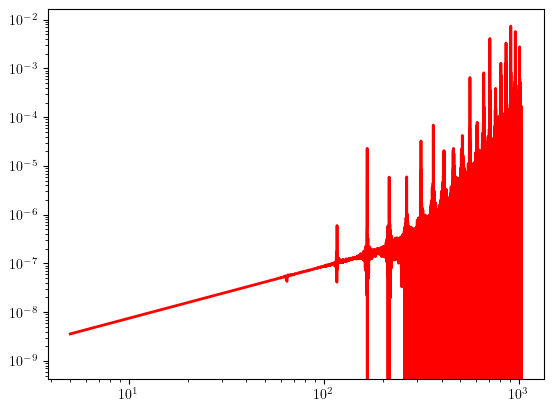

In [50]:
# Sample from Simulator

n_samples = 10000
fref = 25
CE_PSD = np.genfromtxt("data/cosmic_explorer_40km_for_paper.txt")
CE_PSD[0, 0]  = 4.99999999999999999
CE_PSD[:, 1] = CE_PSD[:, 1]**2
gamma_HL = np.genfromtxt("data/gamma_HL.txt")
T_obs = 365 * 24 * 3600

sim = Simulator(fref, CE_PSD, gamma_HL, T_obs, bounds=None)

obs = sim.sample(conditions = {'z': np.array([5e-8, 2.1])})
sims = sim.sample(N = n_samples)

samples = swyft.Samples(x=sims['x'][1:], z=sims['z'][1:])
obs = swyft.Sample(x=sims['x'][0], z=sims['z'][0] )
plt.loglog(sim.freq, obs['x'], 'r', lw=2)

In [51]:
obs

Sample({'x': array([ 3.5725025e-09,  3.7690193e-09,  3.9505936e-09, ...,
       -5.2994164e-05,  3.6991514e-05, -2.2911216e-05], dtype=float32), 'z': array([1.9936380e-08, 1.0670227e+00], dtype=float32)})

In [52]:
# Define swyft network

import torch.nn as nn
import torch.nn.functional as F

class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()

        # VAE
        self.summarizer =  nn.Sequential(nn.Linear(4076, 1024),
                                         nn.Linear(1024, 256),
                                         nn.Linear(256, 64),
                                         nn.Linear(64, 16),
                                         )
        
            #self.dropout(self.reparameterize(self.encode(x)))
           # mu, logvar = self.encode(x)
           # z = self.reparameterize(mu, logvar)
           # z = self.dropout(z)

        # Log-ratio estimator with 1 feature (x) and 2 parameters (alpha, omega)
        self.logratios = swyft.LogRatioEstimator_1dim(
            num_features=16,  # Number of features in compressed x (simulated observation)
            num_params=2,    # Two parameters to infer: alpha and omega
            varnames='z',  # Names of the parameters
            num_blocks=4     # Number of neural network blocks
        )

    def forward(self, A, B):
        s = self.summarizer(A['x'])
        #s = s.unsqueeze(-1)
        return self.logratios(s, B['z'])
    
    #def reparameterize(self, mu, logvar):
        # Reparameterization trick: z = mu + sigma * epsilon
     #   std = torch.exp(0.5 * logvar)
     #   eps = torch.randn_like(std) # random noise
     #   z = mu + eps * std # latent variable
     #   return z
    

In [53]:
# Check that summarizer works

summarizer = nn.Sequential(nn.Linear(4076, 1024),
            nn.Linear(1024, 256),
            nn.Linear(256, 64),
            nn.Linear(64, 16),
            )

np.shape(summarizer(torch.tensor(samples['x'])))

RuntimeError: mat1 and mat2 must have the same dtype, but got Float and Double

In [54]:
trainer = swyft.SwyftTrainer(accelerator=DEVICE, precision=64)

# Step 4: Prepare the data module for training
dm = swyft.SwyftDataModule(samples, batch_size=128)

# Step 5: Instantiate and train the network
network = Network()
trainer.fit(network, dm)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name       | Type                   | Params
------------------------------------------------------
0 | summarizer | Sequential             | 4.5 M 
1 | logratios  | LogRatioEstimator_1dim | 71.0 K
------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total p

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 6: 100%|██████████| 79/79 [00:06<00:00, 12.34it/s, loss=-0.577, v_num=17, val_loss=-0.165] 
Reloading best model: /Users/abbystokes/Documents/GitHub/SBI_SGWB_DSMMA/Abby/lightning_logs/version_17/checkpoints/epoch=1-step=126.ckpt


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.96it/s]


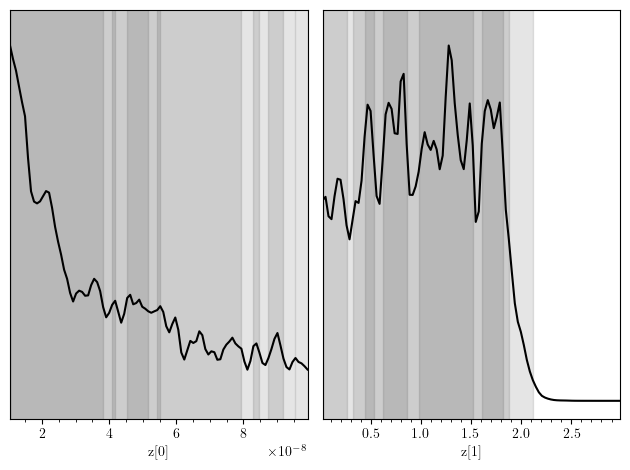

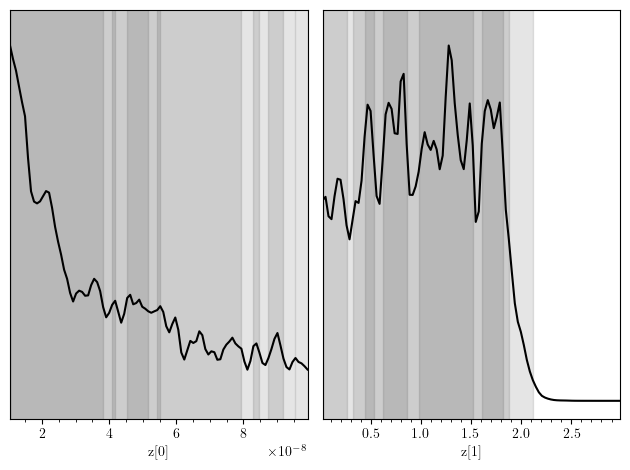

In [61]:
# Define priors
omega_prior = stats.loguniform(1e-8, 1e-7)  # Log-uniform distribution for alpha
alpha_prior = stats.uniform(0, 3)            # Uniform distribution for the second parameter

# Sample 1000 points from the priors
z_omega = omega_prior.rvs(1000)
z_alpha = alpha_prior.rvs(1000)

z_samps = np.column_stack((z_omega, z_alpha))

# Create prior samples
prior_samples = swyft.Samples(z = z_samps)
predictions = trainer.infer(network, obs, prior_samples)

#truth = {k: v for k, v in zip(["z[%i]"%i for i in range(3)], obs['z'])}
swyft.plot_posterior(predictions, ["z[%i]"%i for i in range(2)])